In [1]:
import pandas as pd
import numpy as np
import re
import os
!pip install sentencepiece
import sentencepiece as spm
import pickle
import pathlib
from fastai.text import *
torch.cuda.set_device(0)

     |████████████████████████████████| 1.1MB 3.5MB/s 


In [2]:

import fastai, torch
fastai.__version__ , torch.__version__

('1.0.61', '1.5.1+cu101')

In [3]:
data_df = pd.read_parquet('drive/My Drive/nlp-telugu/telugu_news_dataset.parquet')
data_df.shape, data_df.columns

((20527, 3), Index(['title', 'text', 'category'], dtype='object'))

In [4]:
data_df['t'] = (data_df['title'] + ' ' + data_df['text']).tolist()
data_df['t'].str.len().mean(), data_df['t'].str.len().min(), data_df['t'].str.len().max()# in characters

(1172.7989477273834, 1, 14027)

In [5]:
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(data_df, test_size=0.2)
train_df.shape, test_df.shape

((16421, 4), (4106, 4))

In [40]:
train_df.to_parquet('telugu_news_train.parquet', index = None)
test_df.to_parquet('telugu_news_test.parquet', index = None)

In [7]:
sp = spm.SentencePieceProcessor()
sp.Load('tokenizer.model')
itos = [sp.IdToPiece(int(i)) for i in range(25000)] # 25,000 is the vocab_size selected in sm tokenizer
telugu_vocab = Vocab(itos)

In [8]:
from inltk.tokenizer import TeluguTokenizer
tokenizer = Tokenizer(tok_func=TeluguTokenizer, lang='te')
tokenizer.special_cases

['xxunk',
 'xxpad',
 'xxbos',
 'xxeos',
 'xxfld',
 'xxmaj',
 'xxup',
 'xxrep',
 'xxwrep']

In [9]:
data_lm = TextLMDataBunch.from_df('./', train_df=train_df, valid_df=test_df,
                                  text_cols=["t"], bs=96,
                                  tokenizer=tokenizer, vocab=telugu_vocab) # default bs=64
data_lm.save('telugu_cls_lm.data')

In [10]:
data_lm.show_batch()

idx,text
0,"నా ▁( 48 ▁నాట ౌట్ ▁) ▁సత్తా ▁చాట డంతో ▁భారత్ ▁400 ▁దాట గలిగింది . ▁అనంతరం ▁తొలి ▁ఇన్నింగ్స్ ▁లో ▁దక్షిణాఫ్రికా - ఎ ▁తడ బడింది . ▁కు ల్ ▁ దీప్ ▁యాదవ్ ▁(2 ▁/ ▁51 ), ▁నదీ మ్ ▁(2 ▁/ ▁41 ) ▁విజృంభించ డంతో ▁ఆట ▁ముగిసే ▁సమయానికి ▁159 ▁పరుగుల కే ▁5 ▁వికెట్లు ▁చే జార్ చ ుకుంది . ▁ఓ పె నర్ ▁మార్ ▁క్రమ ్ ▁( 81 ▁బ్యాటింగ్ ▁) ▁చక్కని ▁ఇన్నింగ్స్ ▁ఆడాడు . ▁అతడికి ▁తోడుగా"
1,"▁కేంద్రపాలిత ▁ప్రాంతాల ▁లెఫ్టినెంట్ ▁గవర్నర్ లు , ▁కేంద్ర ▁మంత్రులు ▁తదితరులు ▁పాల్గొన నున్నారు . ▁x x bo s ▁ఇక ▁ట్రాన్స్ ▁జె ండర్ లు ▁ఆడే య ొచ్చు ! ▁క్రికెట్ ▁ఆస్ట్రేలియా ▁నిర్ణయం ▁సిడ్నీ : ▁లింగ ▁మార్పిడి ▁చేసుకున్న ▁వ్యక్తులు ▁( ట్రాన్ స్ ▁జె ండర్ లు ) ▁క్రికెట్ లో ▁ప్రా తిని థ్య ం ▁వహించే ▁విషయంపై ▁ఆస్ట్రేలియా ▁బోర్డు ▁సంచలన ▁నిర్ణయం ▁తీసుకుంది . ▁టె స్టో స్టి రాన్ ▁పరిమితులు ▁విధ ిస్తూ ▁రాష్ట్ర , ▁జాతీయ ▁మహిళా ▁జట్ల ▁తరపున ▁ట్రాన్స్ ▁జె"
2,చ్ఛ ికంగా ▁మే ం ▁ఈ ▁రోజు ▁రామోజీ ▁ఫిలిం సిటీ లో ▁చిత్రీకరణ లో ▁ఉన్నా ం . ▁18 ▁ఏళ్ల ▁కి ందట ▁మే ం ▁ఇక్కడ ▁ఈ ▁షాట్ ▁ని ▁తీ శా ం . ▁చాలా ▁మార్పులు ▁చోటు ▁చేసుకొన్న ాయి . ▁కానీ ▁జక్క న్న తో ▁కలిసి ▁పనిచేయడం ▁ఎప్పుడూ ▁సర దా గా ▁ఉంటుంది ’’ ▁అంటూ ▁ ట్ వీ ట్ ▁చేశారు ▁ఎన్టీఆర్ ▁ . ▁‘‘ ప ద్దె ని మిది ▁సంవత్సరాల ▁కి ందట ▁సరిగ్గా ▁ఇదే ▁రోజు ▁‘ స్ టూ
3,ు ▁అసౌకర్య ానికి ▁గుర య్య ారని ▁తప్పుడు ▁వార్తలు ▁వచ్చాయి . ▁దీనికి ▁సంబంధించిన ▁ఓ ▁వీడియో ▁యూ ట్యూ బ్ ▁లో ▁వై రల్ ▁గా ▁మారింది . ▁ఈ ▁విషయం ▁గురించి ▁శనివారం ▁జరిగిన ▁ప్రీ ▁రిలీజ ్ ▁వేడుక లో ▁రాజేంద్రప్రసాద్ ▁స్పందించ ారు . ▁‘ నేను ▁చదువుకున్న ▁నట ుడిని . ▁నేను ▁సీనియర్ ▁ఎన్టీఆర్ ▁లాగా ▁పాత్రలో ▁లీనమ ై పోయి ▁నటి స్తు ంటా ను . ▁ఎందుకంటే ▁నన్ను ▁ఇండస్ట్రీ కు ▁పరిచయం ▁చేసింది ▁ఆయనే . ▁ఆయన ▁ఓ ▁పాత్రలో ▁నటిస్తున్న ప్పుడు ▁ఇంటికి
4,"▁ఏప్రిల్ ▁1 ▁నుంచి ▁స్వీకరించ ను న్నట్లు ▁పేర్కొంది . ▁20 21 ▁సీజన్ ▁లో ▁హెచ్ ▁ -1 బీ ▁వీసా ల ▁కింద ▁విదేశీ ▁ఉద్యోగుల ను ▁నియమించ ుకో వ ాలనుకునే ▁కంపెనీలు ▁మార్చి ▁1 ▁నుంచి ▁20 ▁వరకూ ▁ఆన్ ▁లైన్ ▁రిజిస్ట్రేషన్ ▁చేస ుకోవాల్సి ▁ఉంటుంది . ▁x x bo s ▁ఆర్ చ రీ లో ▁రంగారెడ్డి కి ▁నాలుగు ▁పతకాలు ▁జ్యోతి నగర్ ▁ , ▁న్యూస్ ▁టు డే : ▁పెద్దపల్లి ▁జిల్లా ▁రామగుండం లో ▁రాష్ట్ర ▁పాఠశాల ▁క్రీడల ▁సమాఖ్య ▁ఆధ్వర్యంలో ▁జరుగుతున్న ▁అండర్"


In [11]:
learn = load_learner('drive/My Drive/nlp-telugu/transformer/', 'export.pkl')

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:657: SourceChangeWarning: source code of class 'torch.nn.modules.loss.CrossEntropyLoss' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:657: SourceChangeWarning: source code of class 'torch.nn.modules.container.ModuleList' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:657: SourceChangeWarning: source code of class 'torch.nn.modules.linear.Linear' has changed. you can retrieve the original source code by accessing the object's source attribute

In [14]:
!cp -r 'drive/My Drive/nlp-telugu/transformer/models/trained_model.pth' 'models/'

In [12]:
learn.save("./trained_model", return_path=True)

PosixPath('drive/My Drive/nlp-telugu/transformer/models/trained_model.pth')

In [15]:

learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.25)
learn = learn.to_fp16(clip=0.1)

In [16]:
learn.load('trained_model', with_opt=True)

/usr/local/lib/python3.6/dist-packages/fastai/basic_train.py:279: UserWarning: Saved filed doesn't contain an optimizer state.
  if with_opt: warn("Saved filed doesn't contain an optimizer state.")


RuntimeError: ignored

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


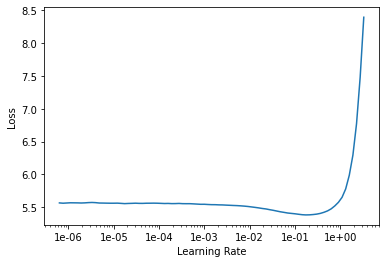

In [ ]:
learn.lr_find()
learn.recorder.plot()

In [17]:
learn.freeze()
learn.fit_one_cycle(2, 1e-2, moms=(0.8,0.7))
learn.save('fit_head', with_opt=True)

epoch,train_loss,valid_loss,accuracy,time
0,4.883865,4.717376,0.284560,11:01
1,4.442290,4.407163,0.313722,11:02


In [18]:
learn.load('fit_head', with_opt=True)

LanguageLearner(data=TextLMDataBunch;

Train: LabelList (16421 items)
x: LMTextList
▁x x bo s ▁పట్టు బి గ ించిన ▁భారత్ ▁- ఎ ▁మైసూరు : ▁దక్షిణాఫ్రికా - ఎ తో ▁రెండో ▁అనధికార ▁టెస్టు పై ▁భారత్ ▁- ఎ ▁పట్టు బి గ ించింది . ▁ఓవర్ ▁నైట్ ▁స్కోరు ▁23 3 ▁/ ▁3 తో ▁రెండో ▁రోజు , ▁బుధవారం ▁తొలి ▁ఇన్నింగ్స్ ▁కొన సా ంచిన ▁భారత్ ▁- ఎ ▁4 17 ▁పరుగుల కు ▁ఆ లౌ ట ైంది . ▁శివ మ్ ▁దు బె ▁( 68 ), ▁జల జ్ ▁స క్ సే నా ▁( 48 ▁నాట ౌట్ ▁) ▁సత్తా ▁చాట డంతో ▁భారత్ ▁400 ▁దాట గలిగింది . ▁అనంతరం ▁తొలి ▁ఇన్నింగ్స్ ▁లో ▁దక్షిణాఫ్రికా - ఎ ▁తడ బడింది . ▁కు ల్ ▁ దీప్ ▁యాదవ్ ▁(2 ▁/ ▁51 ), ▁నదీ మ్ ▁(2 ▁/ ▁41 ) ▁విజృంభించ డంతో ▁ఆట ▁ముగిసే ▁సమయానికి ▁159 ▁పరుగుల కే ▁5 ▁వికెట్లు ▁చే జార్ చ ుకుంది . ▁ఓ పె నర్ ▁మార్ ▁క్రమ ్ ▁( 81 ▁బ్యాటింగ్ ▁) ▁చక్కని ▁ఇన్నింగ్స్ ▁ఆడాడు . ▁అతడికి ▁తోడుగా ▁ముల్ దర్ ▁( 9) ▁క్రీ జు లో ▁ఉన్నాడు . ▁బ్ర ు యిన్ ▁41 ▁పరుగులు ▁చేశాడు .,▁x x bo s ▁చైనాలో ▁భూకంపాలు ▁: ▁12 ▁మంది ▁మృతి ▁125 ▁మందికి ▁గాయాలు ▁బీజింగ్ ▁: ▁చైనా ▁నైరుతి ▁ప్రాంతంలోని ▁సి చు వాన్ ▁ప్రావిన్స్ ▁లో ▁సోమవారం ▁సంభవించిన ▁రెండు ▁భూకంప ాల ▁ధా

In [20]:
import warnings
warnings.filterwarnings("ignore")

In [21]:
learn.unfreeze()
learn.fit_one_cycle(3, 1e-2, moms=(0.8,0.7))
learn.save('fine_tuned', with_opt=True)
learn.save_encoder('fine_tuned_encoder')

epoch,train_loss,valid_loss,accuracy,time
0,4.185667,4.192355,0.326306,13:04
1,3.799003,3.768838,0.373089,13:03
2,3.329849,3.591695,0.395876,13:05


In [22]:
del data_lm, learn

In [23]:
import gc
gc.collect()

391

In [24]:
torch.cuda.empty_cache()

In [25]:
data_clas = TextClasDataBunch.from_df('./', train_df=train_df, valid_df=test_df,
                                  text_cols=["t"], label_cols = ['category'], bs=48,
                                  tokenizer=tokenizer, vocab=telugu_vocab)

In [26]:
data_clas.show_batch()


text,target
▁x x bo s ▁మనం ▁అ జేయ ుల ం ▁ఎదురు లేని ▁టీ మ్ ▁ఇండియా ▁పాక్ ▁పై ▁కొనసాగిన ▁జై త్ర యాత్ర ▁రో హి త్ ▁సూపర్ ▁సెంచరీ ▁మాయ ▁చేసిన ▁కు ల్ ▁ దీప్ ▁4 ▁మార్చి ▁1992 . . ▁9 ▁మార్చి ▁1996 . . ▁8 ▁జూన్ ▁1999 . . ▁1 ▁మార్చి ▁2003 . . ▁30 ▁మార్చి ▁2011 . . ▁15 ▁ఫిబ్రవరి ▁2015 . . ▁భారత ▁క్రికెట్ ▁అభిమానుల ▁హృదయ ాలు ▁ఉప్ప ొ ంగ ేలా,eenadu_sports
"▁x x bo s ▁ ఛే దం చేశారు ▁కో హ్ లి ▁కెప్టెన్ ▁ఇన్నింగ్స్ ▁రాణించ ిన ▁రాహుల్ ▁ , ▁రో హి త్ ▁శా ర్ దూ ల్ ▁ , ▁జ డే జా ▁కొస ▁మెరుపు లు ▁మూడో ▁వన్డే ▁భారత్ ▁దే ▁సూపర్ ▁ఫా మ్ ▁లో ▁ఉన్న ▁రో హి త్ ▁మళ్లీ ▁మెరి శాడు . ▁జో రు ▁కొనసాగిస్తూ ▁రాహుల్ ▁మరో ▁విలువైన ▁ఇన్నింగ్స్ ▁ఆడాడు . ▁కెప్టెన్ ▁కో హ్ లి ▁ఇన్నింగ్స్ ▁కు ▁వెన్నెముక లా ▁నిలిచి , ▁ఇబ్బందుల ్లో",eenadu_sports
"▁x x bo s ▁మనం ▁మారి పో యాం . . . ▁తెలుస ా . . !! ▁మనం ▁మారి పో యాం . . ▁తెలుస ా . . . !! ▁అవు న ండీ ▁మనం ▁మారి పో యాం . . . ▁చాలా ▁చాలా . . ▁స్ మార్ ట్ ▁ఫోన్ ▁వచ్చే సింది . . . ▁మన ▁ప్రపంచ ాన్ని ▁చిన్నది ▁చేసే సింది . ▁అమెజాన్ ▁ప్రై మ్ ▁లో నో , ▁నెట్ ▁ఫ్ల ి క్స్ ▁లో నో",eenadu_business
▁x x bo s ▁సున్నా కు ▁సున్నా ▁రాహుల్ ▁శతకం ▁వృథా ▁మళ్లీ ▁ఓడి న ▁కో హ్ లీ సేన ▁వన్డే ▁సిరీస్ ▁లో ▁టీ మ్ ▁ఇండియా ▁వైట్ ▁వా ష్ ▁టీ 20 ▁పరాభవ ానికి ▁బదులు ▁తీర్చ ుకున్న ▁కి వీ స్ ▁టీ 20 ల ంటే ▁ఎ ప్పుడే ం ▁జరుగ ుతుందో ▁చెప్ప లే ం . ▁ఏ ▁జట్టు ▁మరే ▁జట్టు నైనా ▁ఓడించ ేయ ొచ్చు ! ▁ఆ ▁ఫార్మాట్ లో ▁నిలకడ గా ▁విజయాలు ▁సాధించడం ▁అంత ▁సు లు వు ▁కాదు,eenadu_sports
"▁x x bo s ▁తెలుగు ▁సినిమా కి ▁అత్త ె సరు ▁మార్ కు లే ! ▁సినిమా ▁ఓ ▁విచిత్రమైన ▁వ్యాపారం . ▁ఓ ▁ఫ్యాక్టరీ ▁స్థాపించి ▁నష్ట పోయిన ా ▁- ▁కనీసం ▁దాని ▁తా లు కూ ▁స్థిర , ▁చర ▁ఆస్తుల ైనా ▁మిగులు తాయి . ▁సినిమా ▁అలా ▁కాదు . ▁పోతే . . . ▁అంతా ▁పోయిన ట్టే . ▁రూ . కోట్ల తో ▁తీసిన ▁సినిమా ▁అయినా ▁తేడా ▁వస్తే ▁రూపాయి ▁కూడా ▁మి గలదు . ▁ఒక్కోసారి ▁పది ▁రూపాయలు ▁ పెడితే",eenadu_cinema


In [27]:

learn = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5)

In [28]:
learn.load_encoder('fine_tuned_encoder')


RNNLearner(data=TextClasDataBunch;

Train: LabelList (16421 items)
x: TextList
▁x x bo s ▁పట్టు బి గ ించిన ▁భారత్ ▁- ఎ ▁మైసూరు : ▁దక్షిణాఫ్రికా - ఎ తో ▁రెండో ▁అనధికార ▁టెస్టు పై ▁భారత్ ▁- ఎ ▁పట్టు బి గ ించింది . ▁ఓవర్ ▁నైట్ ▁స్కోరు ▁23 3 ▁/ ▁3 తో ▁రెండో ▁రోజు , ▁బుధవారం ▁తొలి ▁ఇన్నింగ్స్ ▁కొన సా ంచిన ▁భారత్ ▁- ఎ ▁4 17 ▁పరుగుల కు ▁ఆ లౌ ట ైంది . ▁శివ మ్ ▁దు బె ▁( 68 ), ▁జల జ్ ▁స క్ సే నా ▁( 48 ▁నాట ౌట్ ▁) ▁సత్తా ▁చాట డంతో ▁భారత్ ▁400 ▁దాట గలిగింది . ▁అనంతరం ▁తొలి ▁ఇన్నింగ్స్ ▁లో ▁దక్షిణాఫ్రికా - ఎ ▁తడ బడింది . ▁కు ల్ ▁ దీప్ ▁యాదవ్ ▁(2 ▁/ ▁51 ), ▁నదీ మ్ ▁(2 ▁/ ▁41 ) ▁విజృంభించ డంతో ▁ఆట ▁ముగిసే ▁సమయానికి ▁159 ▁పరుగుల కే ▁5 ▁వికెట్లు ▁చే జార్ చ ుకుంది . ▁ఓ పె నర్ ▁మార్ ▁క్రమ ్ ▁( 81 ▁బ్యాటింగ్ ▁) ▁చక్కని ▁ఇన్నింగ్స్ ▁ఆడాడు . ▁అతడికి ▁తోడుగా ▁ముల్ దర్ ▁( 9) ▁క్రీ జు లో ▁ఉన్నాడు . ▁బ్ర ు యిన్ ▁41 ▁పరుగులు ▁చేశాడు .,▁x x bo s ▁చైనాలో ▁భూకంపాలు ▁: ▁12 ▁మంది ▁మృతి ▁125 ▁మందికి ▁గాయాలు ▁బీజింగ్ ▁: ▁చైనా ▁నైరుతి ▁ప్రాంతంలోని ▁సి చు వాన్ ▁ప్రావిన్స్ ▁లో ▁సోమవారం ▁సంభవించిన ▁రెండు ▁భూకంప ాల ▁ధాటికి 

In [29]:
learn.freeze()

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


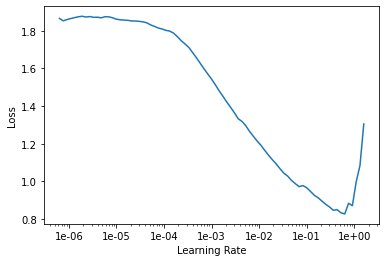

In [30]:
learn.lr_find()
learn.recorder.plot()

In [37]:
kappa = KappaScore()
learn.metrics = [accuracy]

In [38]:
torch.cuda.empty_cache()


In [39]:
learn.fit_one_cycle(3, 1e-2, moms=(0.8,0.7))
learn.save('first_cls', with_opt=True)

epoch,train_loss,valid_loss,accuracy,time
0,0.182688,0.160605,0.944228,03:41
1,0.163754,0.130074,0.953483,03:52
2,0.141389,0.128242,0.954700,03:58


In [42]:
!cp -r 'telugu_news_test.parquet' 'drive/My Drive/nlp-telugu/'

In [43]:
learn.export('classifier.pkl')

In [44]:
!cp -r 'classifier.pkl' 'drive/My Drive/nlp-telugu/ulmfit2'